In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
from keras.preprocessing import image, sequence
from keras.applications import VGG16
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector
from keras.models import Sequential, Model
from keras.optimizers import Nadam

Downloading the data which is share for *Project 5*

In [4]:
!gdown -O P5_Image_Caption.zip --fuzzy 'https://drive.google.com/file/d/1CCL55BqMhTV_cMI3mNaEizuJSA6QkBY1/view?usp=share_link'

Downloading...
From: https://drive.google.com/uc?id=1CCL55BqMhTV_cMI3mNaEizuJSA6QkBY1
To: /content/P5_Image_Caption.zip
100% 1.13G/1.13G [00:05<00:00, 218MB/s]


In [5]:
!mkdir /content/P5_Image_Captioning/

In [6]:
!unzip -q P5_Image_Caption.zip -d '/content/P5_Image_Captioning/'

mapname:  conversion of  failed


In [7]:
images_dir = os.listdir("/content/P5_Image_Captioning/Flicker8k_Dataset/")

images_path = '/content/P5_Image_Captioning/Flicker8k_Dataset/'
captions_path = '/content/P5_Image_Captioning/Flickr8k_text/Flickr8k.lemma.token.txt'
train_path = '/content/P5_Image_Captioning/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '/content/P5_Image_Captioning/Flickr8k_text/Flickr_8k.devImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_test = open(val_path, 'r').read().split("\n")

In [8]:
captions[2]

'1305564994_00513f9a5b.jpg#2\tTwo motorist be ride along on their vehicle that be oddly design and color .'

In [9]:
x_train[2]

'3338291921_fe7ae0c8f8.jpg'

Mapping the Image with the Caption

In [10]:
tokens = {'222':'test'}

In [11]:
for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    # print(temp)
    if temp[0] in tokens:
        # print(temp[0])
        tokens[temp[0]].append(temp[1][2:])
        # print(temp[1][2:])
    else:
        # print(temp[1][2:])
        tokens[temp[0]] = [temp[1][2:]]

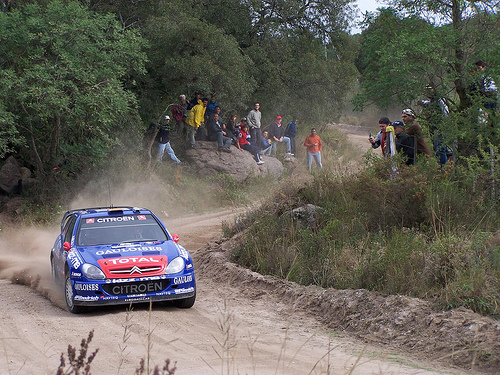

A blue rally car pull away from spectator watch from the side of a track .
A car be be drive on a trail while person on both side of a road look on .
A race car zoom while onlooker watch .
A race car go through a dirt course while fan watch .
Blue race car ride on dirt path with onlooker .


In [12]:
temp = captions[106].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)
for ix in tokens[temp[0]]:
    print(ix)

Check the number of the image and training data

In [13]:
check_files=os.listdir('/content/P5_Image_Captioning/Flicker8k_Dataset')

In [14]:
ck_sum =0
count = 0
for cf in check_files:
    count = count +1
    if cf in tokens:
        ck_sum = ck_sum +1
print(ck_sum, count)

8091 8091


In [15]:
len(tokens)

8093

In [16]:
data = pd.DataFrame(tokens.items(), columns=['file_name', 'Caption']) #pd.DataFrame.from_dict(tokens, orient ='index')

In [17]:
data.shape

(8093, 2)

In [18]:
data['file_name'].isin(check_files).sum()

8091

Image Modeling

In [19]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [20]:
# extract features from image
features = {}
directory = '/content/P5_Image_Captioning/Flicker8k_Dataset/'

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [21]:
# store features in pickle
pickle.dump(features, open(os.path.join('/content/sample_data', 'features.pkl'), 'wb'))

In [22]:
with open(os.path.join('/content/sample_data', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Caption modeling

In [23]:
with open(os.path.join('/content/P5_Image_Captioning/Flickr8k_text/', 'Flickr8k.lemma.token.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [24]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens_1 = line.split('#')
    if len(line) < 2:
        continue
    image_id, caption = tokens_1[0], tokens_1[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40460 [00:00<?, ?it/s]

In [25]:
len(mapping)

8092

In [26]:

check_files=os.listdir('/content/P5_Image_Captioning/Flicker8k_Dataset')

In [27]:
ck_sum =0
count = 0
check_files_name = []
for cf in check_files:
    count = count +1
    cf = cf.split('.')[0]
    if cf in mapping:
        ck_sum = ck_sum +1
        check_files_name.append(cf)
print(ck_sum, count)

8091 8091


In [28]:
remove_these=[]
encoded_images={}
for i in mapping:
    if i not in check_files_name:
        remove_these.append(i)

In [29]:
len(remove_these)

1

In [30]:
for rt in remove_these:
    if rt in mapping:
        del mapping[rt]

In [31]:
len(mapping)

8091

Pre processing text data

In [32]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [33]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['0\tA child in a pink dress be climb up a set of stair in an entry way .',
 '1\tA girl go into a wooden building .',
 '2\tA little girl climb into a wooden playhouse .',
 '3\tA little girl climb the stair to her playhouse .',
 '4\tA little girl in a pink dress go into a wooden cabin .']

In [34]:
# preprocess the text
clean(mapping)

In [35]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress be climb up set of stair in an entry way endseq',
 'startseq girl go into wooden building endseq',
 'startseq little girl climb into wooden playhouse endseq',
 'startseq little girl climb the stair to her playhouse endseq',
 'startseq little girl in pink dress go into wooden cabin endseq']

In [36]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [37]:
len(all_captions)

40454

In [38]:
all_captions[:10]

['startseq two racer drive white bike down road endseq',
 'startseq two motorist be ride along on their vehicle that be oddly design and color endseq',
 'startseq two person be in small race car drive by green hill endseq',
 'startseq two person in race uniform in street car endseq',
 'startseq firefighter extinguish fire under the hood of car endseq',
 'startseq fireman spray water into the hood of small white car on jack endseq',
 'startseq fireman spray inside the open hood of small white car on jack endseq',
 'startseq fireman use firehose on car engine that be up on carjack endseq',
 'startseq firefighter use water to extinguish car that be on fire endseq',
 'startseq boy sand surf down hill endseq']

In [39]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [40]:
vocab_size

6438

In [41]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [42]:
for xt in range(len(x_train)):
    x_train[xt] = x_train[xt].split('.')[0]

In [43]:
for xt in range(len(x_test)):
    x_test[xt] = x_test[xt].split('.')[0]

In [44]:
image_ids = list(mapping.keys())
train = x_train
test = x_test

In [45]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [46]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Model 

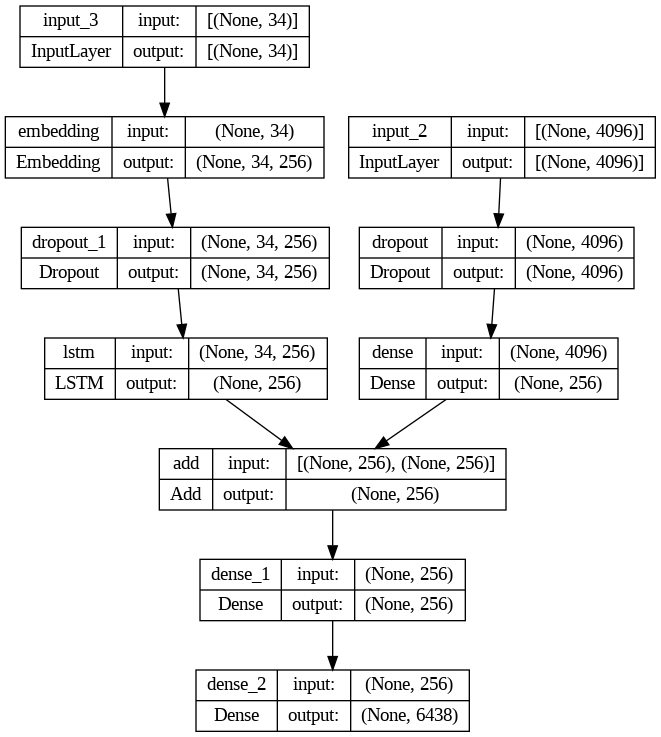

In [47]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [48]:
import tensorflow as tf

from tensorflow import keras
model = tf.keras.models.load_model('/content/sample_data/best_model.h5')

In [49]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

 18/187 [=>............................] - ETA: 1:33 - loss: 1.7605

KeyboardInterrupt: ignored

In [50]:
# save the model
model.save('/content/sample_data'+'/best_model.h5')

Generate Captions for the Image

In [51]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [52]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [53]:
remove_these=[]
encoded_images={}
for i in tqdm(test):
    if i not in check_files_name:
        remove_these.append(i)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [54]:
remove_these

['']

In [55]:
for rt in remove_these:
    if rt in test:
        test.remove(rt)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.560092
BLEU-2: 0.330610


In [56]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/P5_Image_Captioning/Flicker8k_Dataset', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq couple of person sit outdoors at table with an umbrella and talk endseq
startseq three person be sit at an outside picnic bench with an umbrella endseq
startseq three person sit at an outdoor cafe endseq
startseq three person sit at an outdoor table in front of building paint like the union jack endseq
startseq three person sit at picnic table outside of building paint like union jack endseq
--------------------Predicted--------------------
startseq two person be stand on street with ribbon endseq


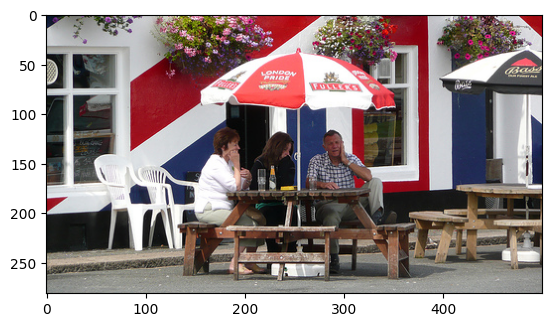

In [57]:
generate_caption("1258913059_07c613f7ff.jpg")

---------------------Actual---------------------
startseq child be lay in bubble bath hold yellow scrub brush up to his mouth as if sing into microphone endseq
startseq child sing into loofa in bathtub endseq
startseq little boy be lay down in bubble bath endseq
startseq boy in bubble bath yell or sing into scrub brush endseq
startseq child be surround by bubble while in bathtub endseq
--------------------Predicted--------------------
startseq two child be in the bathroom endseq


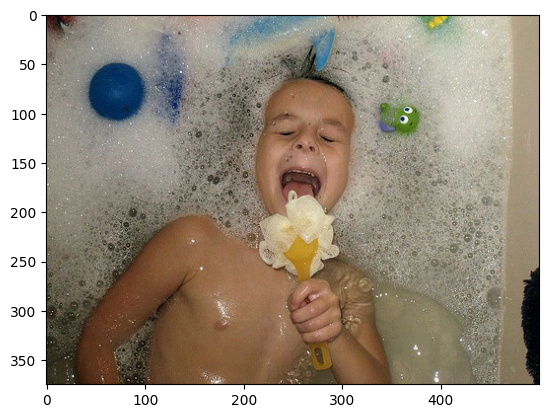

In [58]:
generate_caption("1579798212_d30844b4c5.jpg")


Test

In [59]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [60]:
image_path = '/content/P5_Image_Captioning/Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq young girl be stand in front of wooden playhouse endseq'

In [61]:
images_path = '/content/P5_Image_Captioning/Flicker8k_Dataset/'
test_path = '/content/P5_Image_Captioning/Flickr8k_text/Flickr_8k.testImages.txt'

x_output = open(test_path, 'r').read().split("\n")

In [62]:
remove_these=[]
print(len(remove_these))
for i in x_output:
    if i not in check_files:
        remove_these.append(i)
len(remove_these)

0


1

In [63]:
for rt in remove_these:
    if rt in x_output:
        x_output.remove(rt)

In [64]:
len(x_output)

1000

In [65]:
output = {}
for xo in tqdm(x_output):
    xo_img_path = images_path + xo
    xo_img = load_img(xo_img_path,target_size=(224, 224))
    xo_img = img_to_array(xo_img)
    xo_img = xo_img.reshape((1, xo_img.shape[0], xo_img.shape[1], xo_img.shape[2]))
    xo_img = preprocess_input(xo_img)
    feature = vgg_model.predict(xo_img, verbose=0)
    xo_pred = predict_caption(model, feature, tokenizer, max_length)
    xo_pred = xo_pred.replace('startseq ','',1)
    xo_pred = xo_pred.replace(' endseq','',1)
    output[xo] = [xo_pred] 

  0%|          | 0/1000 [00:00<?, ?it/s]

In [66]:
data_pred = pd.DataFrame(output.items(), columns=['file_name', 'Prediction Caption']) #pd.DataFrame.from_dict(tokens, orient ='index')

In [69]:
out_acut = []
for xo in x_output:
    out_acut.append(tokens[xo])

In [67]:
tokens[x_output[5]]

['A brown dog run',
 'A brown dog run over grass .',
 'A brown dog with its front paw off the ground on a grassy surface near red and purple flower .',
 'A dog run across a grassy lawn near some flower .',
 'A yellow dog be play in a grassy area near flower .']

In [70]:
data_acut = pd.DataFrame(out_acut, columns=['Actual_Caption_1','Actual_Caption_2','Actual_Caption_3','Actual_Caption_4','Actual_Caption_5']) #pd.DataFrame.from_dict(tokens, orient ='index')

In [71]:
data_acut.head(8)

,Actual_Caption_1,Actual_Caption_2,Actual_Caption_3,Actual_Caption_4,Actual_Caption_5
0,Dog be in the snow in front of a fence .,Dog play on the snow .,Two brown dog playful fight in the snow .,Two brown dog wrestle in the snow .,Two dog play in the snow .
1,a brown and white dog swim towards some in a pool,A dog in a swim pool swim toward sombody we ca...,A dog swim in a pool near a person .,Small dog be paddle through the water in a pool .,A small brown and white dog be in a pool .
2,A man and a woman in festive costume dance .,A man and a woman with feather on her head dan...,A man and a woman wear decorative costume and ...,one performer wear a feathered headdress dance...,Two person be dance with drum on the right and...
3,A couple of person sit outdoors at a table wit...,Three person be sit at an outside picnic bench...,Three person sit at an outdoor cafe .,Three person sit at an outdoor table in front ...,Three person sit at a picnic table outside of ...
4,A man be wear a Sooner red football shirt and ...,A Oklahoma Sooner football player wear his jer...,A Sooner football player weas the number 28 an...,Guy in red and white football uniform,The American footballer be wear a red and whit...
5,A brown dog run,A brown dog run over grass .,A brown dog with its front paw off the ground ...,A dog run across a grassy lawn near some flower .,A yellow dog be play in a grassy area near flo...
6,A girl with dark brown hair and eye in a blue ...,an Asian boy and an Asian girl be smile in a c...,Girl be in a crowd .,Two dark haired girl be in a crowd .,Two girl be look past each other in different ...
7,A dog with its mouth open .,Brown and white dog yawn .,Closeup of dog in profile with mouth open .,Dog yawn,A dog 's mouth be open like he be yawn .


In [72]:
result = pd.concat([data_pred, data_acut], axis=1) 

In [73]:
result.head(10)

,file_name,Prediction Caption,Actual_Caption_1,Actual_Caption_2,Actual_Caption_3,Actual_Caption_4,Actual_Caption_5
0,3385593926_d3e9c21170.jpg,[two dog play with each other in the snow],Dog be in the snow in front of a fence .,Dog play on the snow .,Two brown dog playful fight in the snow .,Two brown dog wrestle in the snow .,Two dog play in the snow .
1,2677656448_6b7e7702af.jpg,[dog be play with toy on the floor],a brown and white dog swim towards some in a pool,A dog in a swim pool swim toward sombody we ca...,A dog swim in a pool near a person .,Small dog be paddle through the water in a pool .,A small brown and white dog be in a pool .
2,311146855_0b65fdb169.jpg,[two young woman be play with plastic bag],A man and a woman in festive costume dance .,A man and a woman with feather on her head dan...,A man and a woman wear decorative costume and ...,one performer wear a feathered headdress dance...,Two person be dance with drum on the right and...
3,1258913059_07c613f7ff.jpg,[two person be stand on street with ribbon],A couple of person sit outdoors at a table wit...,Three person be sit at an outside picnic bench...,Three person sit at an outdoor cafe .,Three person sit at an outdoor table in front ...,Three person sit at a picnic table outside of ...
4,241347760_d44c8d3a01.jpg,[football player in red uniform be in red jers...,A man be wear a Sooner red football shirt and ...,A Oklahoma Sooner football player wear his jer...,A Sooner football player weas the number 28 an...,Guy in red and white football uniform,The American footballer be wear a red and whit...
5,2654514044_a70a6e2c21.jpg,[dog run with toy in its mouth],A brown dog run,A brown dog run over grass .,A brown dog with its front paw off the ground ...,A dog run across a grassy lawn near some flower .,A yellow dog be play in a grassy area near flo...
6,2339106348_2df90aa6a9.jpg,[two girl be wear black sweater],A girl with dark brown hair and eye in a blue ...,an Asian boy and an Asian girl be smile in a c...,Girl be in a crowd .,Two dark haired girl be in a crowd .,Two girl be look past each other in different ...
7,256085101_2c2617c5d0.jpg,[brown and white dog bare its mouth],A dog with its mouth open .,Brown and white dog yawn .,Closeup of dog in profile with mouth open .,Dog yawn,A dog 's mouth be open like he be yawn .
8,280706862_14c30d734a.jpg,[dog be run through the snow],A black dog emerge from the water onto the san...,A black dog emerge from the water with a white...,A black dog on a beach carry a ball in its mou...,a black dog walk out of the water with a white...,Black dog jump out of the water with something...
9,3072172967_630e9c69d0.jpg,[basketball player in blue uniform be run],A player from white and green highschool team ...,Four basketball player in action .,"Four man play basketball , two from each team .",Two boy in green and white uniform play basket...,Young man play basketball in a competition .


In [74]:
from nltk.translate.bleu_score import sentence_bleu

In [95]:
predict_score_1 = []
for rs in tqdm(range(result.shape[0])):
    hypothesis1 = result['Prediction Caption'][rs][0].split()

    reference1 = result['Actual_Caption_1'][rs].split()
    reference2 = result['Actual_Caption_2'][rs].split()
    reference3 = result['Actual_Caption_3'][rs].split()
    reference4 = result['Actual_Caption_4'][rs].split()
    reference5 = result['Actual_Caption_5'][rs].split()
    value_1 = str(sentence_bleu([reference1, reference2, reference3,reference4, reference5], hypothesis1))
    predict_score_1.append(value_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [96]:
print(value_1)

4.932250118548181e-155


In [97]:
data_score_1 = pd.DataFrame(predict_score_1, columns=['Score_1'])

In [98]:
output_data = pd.concat([data_pred, data_score_1], axis=1) 

In [99]:
output_data.head(10)

,file_name,Prediction Caption,Score_1
0,3385593926_d3e9c21170.jpg,[two dog play with each other in the snow],5.072841446586652e-78
1,2677656448_6b7e7702af.jpg,[dog be play with toy on the floor],5.588971591971542e-155
2,311146855_0b65fdb169.jpg,[two young woman be play with plastic bag],1.1103055738259992e-231
3,1258913059_07c613f7ff.jpg,[two person be stand on street with ribbon],7.176381577237209e-155
4,241347760_d44c8d3a01.jpg,[football player in red uniform be in red jers...,8.44152793092278e-155
5,2654514044_a70a6e2c21.jpg,[dog run with toy in its mouth],8.761982757198608e-155
6,2339106348_2df90aa6a9.jpg,[two girl be wear black sweater],7.57965434483665e-155
7,256085101_2c2617c5d0.jpg,[brown and white dog bare its mouth],6.313993041533344e-78
8,280706862_14c30d734a.jpg,[dog be run through the snow],4.310732902257592e-232
9,3072172967_630e9c69d0.jpg,[basketball player in blue uniform be run],6.313993041533344e-78


In [105]:
output_data['Score_1']=output_data['Score_1'].astype(float)

In [109]:
output_data.min(axis=1)

<ipython-input-109-979aaeff0430>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  output_data.min(axis=1)


0       5.072841e-78
1      5.588972e-155
2      1.110306e-231
3      7.176382e-155
4      8.441528e-155
           ...      
995    1.331960e-231
996    1.119310e-231
997    7.535860e-155
998    1.186218e-231
999    4.932250e-155
Length: 1000, dtype: float64

In [112]:
path = '/content/sample_data/outtext.txt'

In [114]:
with open(path,'a') as f:
    output_string = output_data.to_string()
    f.write(output_string)